In [5]:
import pyshtools

coeffs = pyshtools.SHGravCoeffs.from_file("/home/kalvisuser/dev/sandbox/grace-gravity/data/ITSG_ITSG-Grace2014_daily_2004_ITSG-Grace2014_2004-12-26.gfc",format='icgem')

In [10]:
grid=coeffs.expand()

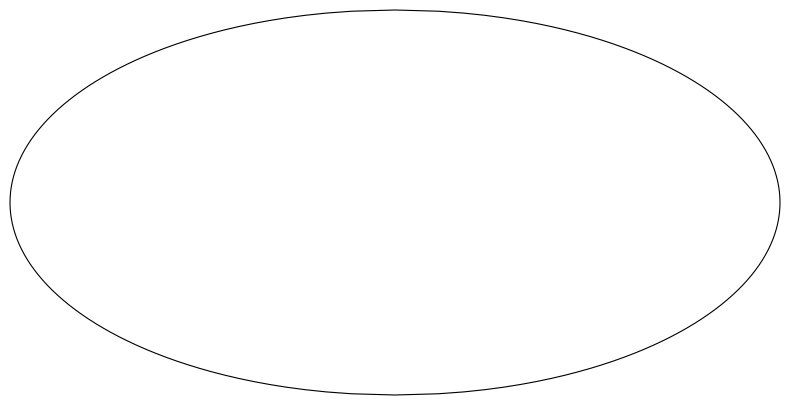

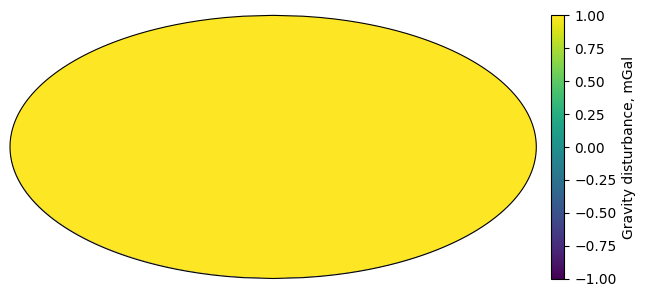

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Define the projection correctly
projection = ccrs.Mollweide()

# Plot the gravity field using the correct projection instance
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': projection})
grid.plot_total(projection=projection, cmap_limits=[-1, 1])
plt.show()


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power, m$^2$'>)

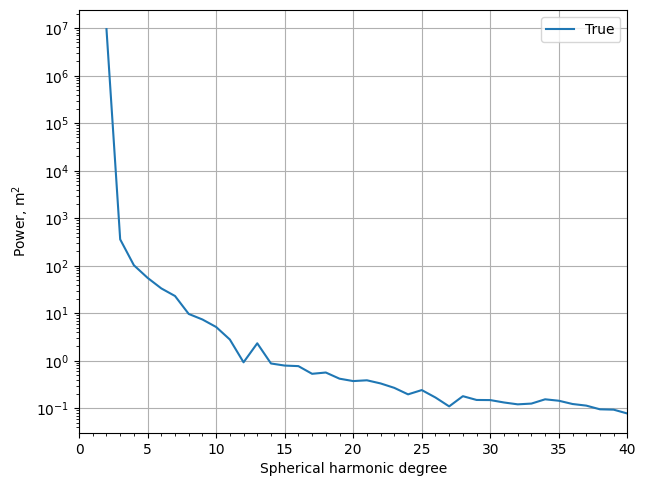

In [6]:
coeffs.plot_spectrum(unit='per_l',xscale='lin',yscale='log',legend=True)

In [8]:
coeffs.plot_correlation

<bound method SHGravCoeffs.plot_correlation of   name = None
  kind = 'real'
  normalization = '4pi'
  csphase = 1
  lmax = 40
  GM (m3 / s2) = 398600441500000.0
  r0 (m) = 6378136.3
  omega (rad / s) = None
  error_kind = None
  header = None
  header2 = None
  epoch = None>

In [ ]:
coeffs = pyshtools.SHGravCoeffs.from_file(
    "ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-15.gfc", format="icgem"
)

coeffs.plot_spectrum(unit="per_l", xscale="lin", yscale="log", legend=True)

In [ ]:
import pyshtools as pysh
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Function to load spherical harmonic coefficients from a GRACE GFC file.
def load_sh_grav_coeffs(gfc_file):
    """Load spherical harmonic coefficients using pyshtools."""
    coeffs = pysh.SHGravCoeffs.from_file(gfc_file, format='icgem')
    return coeffs

# Function to compute gravity anomaly excluding the first 5 degrees.
def compute_gravity_anomaly_excluding_first5(coeffs):
    # Use the provided planetary constants:
    gm = 3.9860044150e+14   # [m^3/s^2]
    r0 = 6.3781363000e+06    # [m]

    # Copy coefficients and zero out degrees 0-4.
    modified_coeffs = coeffs.coeffs.copy()
    modified_coeffs[:, 0:5, :] = 0  # Zero out l = 0 to 4 for both cosine and sine parts

    # Compute gravity components using pyshtools.
    rad, theta, phi, total, pot = pysh.gravmag.MakeGravGridDH(
        modified_coeffs, gm, r0, lmax=coeffs.lmax, normal_gravity=1
    )

    combined_total = np.sqrt(rad**2 + theta**2 + phi**2)

    g_ref = gm / (r0**2)

    total = total + g_ref

    return total

if __name__ == "__main__":
    gfc_file1 = "CSR_CSR-Release-06_60x60_unfiltered_GSM-2_2004306-2004335_GRAC_UTCSR_BA01_0600.gfc"
    gfc_file2 = "CSR_CSR-Release-06_60x60_unfiltered_GSM-2_2004336-2004366_GRAC_UTCSR_BA01_0600.gfc"

    # Load the spherical harmonic coefficients.
    coeffs1 = load_sh_grav_coeffs(gfc_file1)
    coeffs2 = load_sh_grav_coeffs(gfc_file2)

    # Compute the gravity anomalies for the two dates.
    anomaly1 = compute_gravity_anomaly_excluding_first5(coeffs1)
    anomaly2 = compute_gravity_anomaly_excluding_first5(coeffs2)

    # Compute the difference (post-event minus pre-event).
    anomaly_difference = abs(anomaly2 - anomaly1)
    anomaly_difference *= 1e8

    # Set up the grid.
    # Note: MakeGravGridDH returns a grid with dimensions (nlat, 2*nlat) 
    # because it uses a Driscoll & Healy grid.
    grid_size = anomaly2.shape[0]
    latitudes = np.linspace(-90, 90, grid_size)
    longitudes = np.linspace(0, 360, 2 * grid_size, endpoint=False)
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    # ---------------- Global Plot ----------------
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE)
    pcm = ax.contourf(
        lon_grid, lat_grid, anomaly_difference,
        transform=ccrs.PlateCarree(), cmap="RdYlBu_r", levels=20
    )
    plt.colorbar(pcm, ax=ax, label="Gravitational Anomaly Difference (µGal)")
    plt.title("Global Gravitational Anomaly Difference (Nov 15, 2006)")
    plt.show()

    # ---------------- Spatial Localization ----------------
    # Define the earthquake epicenter and a region around it.
    epicenter_lat = 3.316   # example: 55.5° N
    epicenter_lon = 95.854  # example: 161.0° E

    # Define the bounds of the zoomed region (e.g., ±10° around the epicenter)
    lat_min = epicenter_lat - 15
    lat_max = epicenter_lat + 15
    lon_min = epicenter_lon - 15
    lon_max = epicenter_lon + 15

    # Extract localized data for proper scaling
    lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
    lon_mask = (longitudes >= lon_min) & (longitudes <= lon_max)

    local_anomaly = anomaly_difference[np.ix_(lat_mask, lon_mask)]

    # Determine local min/max for color scaling
    local_min = np.min(local_anomaly)
    local_max = np.max(local_anomaly)

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Use the local min/max for contour levels
    pcm = ax.contourf(
        lon_grid, lat_grid, anomaly_difference,
        transform=ccrs.PlateCarree(), cmap="RdYlBu_r",
        levels=np.linspace(local_min, local_max, 20)
    )

    plt.colorbar(pcm, ax=ax, label="Gravitational Anomaly Difference (µGal)")
    plt.show()


In [ ]:
# ---------------- Spatial Localization ----------------
# Define the earthquake epicenter and a region around it.
epicenter_lat = 3.316
epicenter_lon = 95.854

# Define the bounds of the zoomed region (e.g., ±10° around the epicenter)
lat_min = epicenter_lat - 15
lat_max = epicenter_lat + 15
lon_min = epicenter_lon - 15
lon_max = epicenter_lon + 15

# Extract localized data for proper scaling
lat_mask = (latitudes >= lat_min) & (latitudes <= lat_max)
lon_mask = (longitudes >= lon_min) & (longitudes <= lon_max)

local_anomaly = anomaly_difference[np.ix_(lat_mask, lon_mask)]

# Determine local min/max for color scaling
local_min = np.min(local_anomaly)
local_max = np.max(local_anomaly)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

pcm = ax.contourf(
    lon_grid, lat_grid, anomaly_difference,
    transform=ccrs.PlateCarree(), cmap="RdYlBu_r",
    levels=np.linspace(local_min, local_max, 20)
)

plt.colorbar(pcm, ax=ax, label="Gravitational Anomaly Difference (µGal)")
plt.show()